<a href="https://www.kaggle.com/code/dannasalazar11/pca-tarea-entregable?scriptVersionId=167526298" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error, f1_score
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from typing import Optional, Sequence

2024-03-18 00:32:41.263766: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 00:32:41.263902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 00:32:41.408144: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1. Vamos a definir una función para poder graficar algunos elementos del dataset y el dataset reconstruído con PCA, además se muestra la etiqueta del clasificador (en verde si coincidió y en rojo si se equivocó)

In [2]:
def plot_mnist_autoencoder(
    x: Sequence[np.ndarray], 
    x_: Sequence[np.ndarray], 
    y: Optional[Sequence] = None, 
    y_: Optional[Sequence] = None, 
    cmap: str = 'gray', 
    vmin: float = 0, 
    vmax: float = 1
) -> None:
    """
    Plot the original and reconstructed MNIST images using an autoencoder.

    Parameters
    ----------
    x : Sequence[np.ndarray]
        Original images.
    x_ : Sequence[np.ndarray]
        Reconstructed images.
    y : Optional[Sequence], optional
        True labels of the images, by default None.
    y_ : Optional[Sequence], optional
        Predicted labels of the images, by default None.
    cmap : str, optional
        Color map for the images, by default 'gray'.
    vmin : float, optional
        Minimum value for normalization, by default 0.
    vmax : float, optional
        Maximum value for normalization, by default 1.

    Examples
    --------
    >>> plot_mnist_autoencoder(original_images, reconstructed_images)
    """
    plt.figure(figsize=(20, 2))
    for i, (train, predict) in enumerate(zip(x, x_), start=1):
        plt.subplot(2, len(x), i)
        plt.imshow(train.reshape(28, 28), cmap=cmap, vmin=vmin, vmax=vmax)
        plt.axis('off')
        
        plt.subplot(2, len(x), i + len(x))
        plt.imshow(predict.reshape(28, 28), cmap=cmap, vmin=vmin, vmax=vmax)
        plt.axis('off')

        if y is not None and y_ is not None:
            color = "red" if y[i - 1] != y_[i - 1] else 'green'
            plt.text(
                0, 28, str(y_[i - 1]), color=color, fontsize=15, 
                verticalalignment='bottom', horizontalalignment='left'
            )

2. Importamos el DataSet y realizamos el procesamiento del mismo

In [3]:
scale = 0.4
(x_train_, y_train_), (x_test, y_test) = mnist.load_data()
    
# Adding noise and normalizing the data
x_train_ = x_train_.astype('float32') / 255. + np.random.normal(scale=scale, size=x_train_.shape)
x_test = x_test.astype('float32') / 255. + np.random.normal(scale=scale, size=x_test.shape)

# Reshaping and splitting the training data
x_train = x_train_[:50000].reshape(-1, 784)
x_val = x_train_[50000:].reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# Converting labels to categorical format
y_train = to_categorical(y_train_[:50000])
y_val = to_categorical(y_train_[50000:])
y_test = to_categorical(y_test)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


3. Hacemos el custom de una capa densa para poder imponer la restricción de que los pesos sean los transpuestos de otra capa dada

In [4]:
class DenseTied(tf.keras.layers.Layer):
    """
    A custom Keras layer that ties its weights to another layer.

    Parameters
    ----------
    tied_to : tf.keras.layers.Layer
        The layer to which this layer's weights are tied.
    """
    def __init__(self, tied_to: tf.keras.layers.Layer, **kwargs):
        super().__init__(**kwargs)
        self.tied_to = tied_to

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Perform the layer's logic.

        Parameters
        ----------
        x : tf.Tensor
            Input tensor.

        Returns
        -------
        tf.Tensor
            Output tensor after applying the layer logic.
        """
        W = tf.transpose(self.tied_to.weights[0])
        return tf.matmul(x, W)

4. Creamos la red (funcional) y la entrenamos

In [5]:
input_dim = x_train.shape[-1] 
encoding_dim = 46  # dimensionality reduction
num_classes = y_train.shape[-1]

# Input layer
input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoder = tf.keras.layers.Dense(
            encoding_dim,
            use_bias=False,
            kernel_regularizer=tf.keras.regularizers.OrthogonalRegularizer(factor=0.1),
            activation="linear", name = 'encoder')

decoder = DenseTied(encoder, name = 'decoder')
        
classifier = tf.keras.layers.Dense(
            num_classes, 
            activation="softmax", name = "classifier")


encoded = encoder(input_layer)
decoded = decoder(encoded)
classification = classifier(encoded)

# Model
###
model = tf.keras.Model(inputs=input_layer, outputs=[decoded, classification])
model.compile(optimizer='adam', loss=['mean_squared_error', 'categorical_crossentropy'], loss_weights = [0.5,1], metrics=["accuracy","accuracy"])

# Training the PCA_Net model
history = model.fit(
    x_train, (x_train, y_train),  # Training data and labels
    epochs=50,  # Number of epochs
    batch_size=256,  # Batch size
    shuffle=True,  # Shuffling the training data
    validation_data=(x_val, [x_val, y_val])
)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - classifier_accuracy: 0.5994 - decoder_accuracy: 0.0159 - loss: 1.3795 - val_classifier_accuracy: 0.8670 - val_decoder_accuracy: 0.0218 - val_loss: 0.6138
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - classifier_accuracy: 0.8585 - decoder_accuracy: 0.0227 - loss: 0.6180 - val_classifier_accuracy: 0.8709 - val_decoder_accuracy: 0.0257 - val_loss: 0.5691
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - classifier_accuracy: 0.8724 - decoder_accuracy: 0.0247 - loss: 0.5645 - val_classifier_accuracy: 0.8655 - val_decoder_accuracy: 0.0266 - val_loss: 0.5639
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - classifier_accuracy: 0.8776 - decoder_accuracy: 0.0227 - loss: 0.5484 - val_classifier_accuracy: 0.8664 - val_decoder_accuracy: 0.0251 - val_loss: 0.5592
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - classifier_accuracy: 0.8770 - decoder_accuracy: 0.0240 - loss: 0.5467 - val_classifier_accuracy: 0.8636 - val_deco

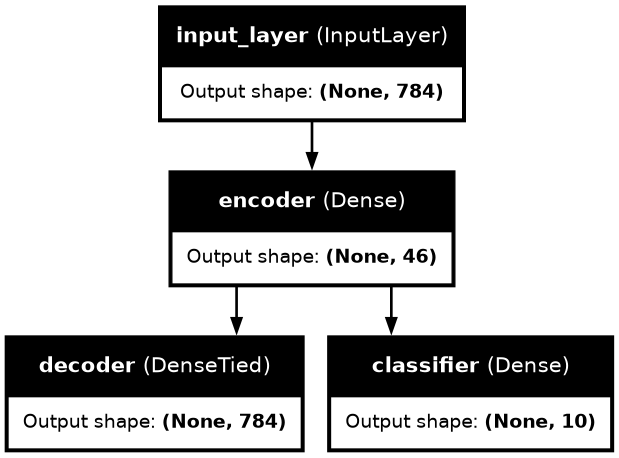

In [6]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True, dpi=96)

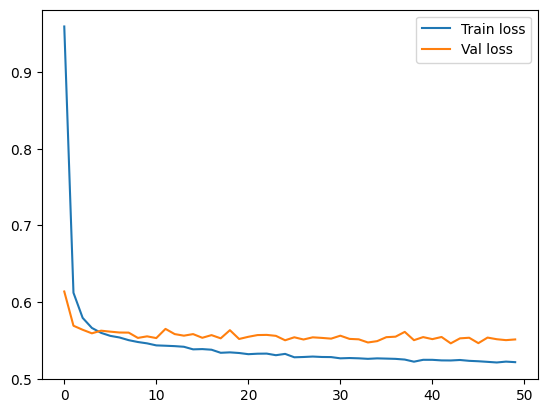

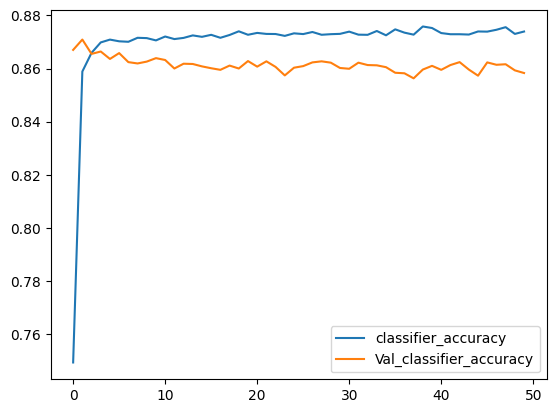

In [7]:
import pandas as pd

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

plt.plot(history.history['classifier_accuracy'], label='classifier_accuracy')
plt.plot(history.history['val_classifier_accuracy'], label='Val_classifier_accuracy')
plt.legend()
plt.show()

5. Ahora hagamos el predict de los datos de test

In [8]:
# Perform predictions with the model
x_pca, y_pca_pred = model.predict(x_test)

# Calculate the Mean Squared Error for the reconstruction
mse_reconstruction = mean_squared_error(x_test.reshape(-1, input_dim), x_pca)

# Prepare the true and predicted labels for calculating the F1 score
# Convert labels from categorical (one-hot) format to single class format
y_test_classes = np.argmax(y_test, axis=1)
y_pca_pred_classes = np.argmax(y_pca_pred, axis=1)

# Calculate the F1 score for classification
f1 = f1_score(y_test_classes, y_pca_pred_classes, average='weighted')

print(f"Mean Squared Error (Reconstruction): {mse_reconstruction}")
print(f"F1 Score (Classification): {f1}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean Squared Error (Reconstruction): 0.195900415789999
F1 Score (Classification): 0.8603577455217839


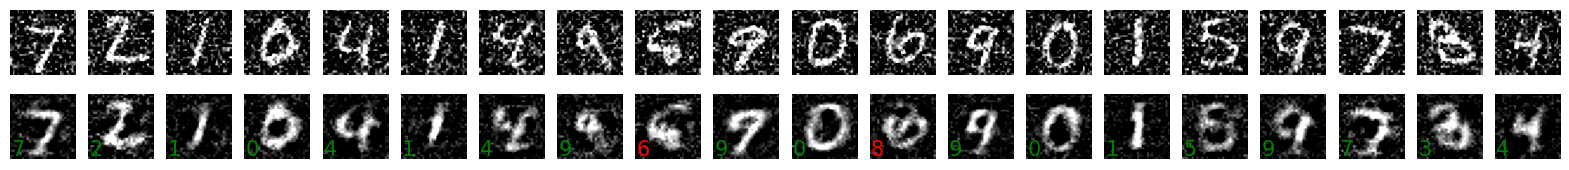

In [9]:
# Set the number of images to display
N = 20

plot_mnist_autoencoder(
    x_test[:N],  # First N original test images
    x_pca[:N],   # First N reconstructed images
    y_test.argmax(axis=1)[:N],  # True labels for the first N images
    y_pca_pred.argmax(axis=1)[:N]    # Predicted labels for the first N images
)